In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units
import random

In [3]:
#Constants
R_cloud = (0.001 * units.pc).cgs
mass_cloud_ksm = const.M_sun
mass_cloud = mass_cloud_ksm.cgs
mass_proton_ksm = const.m_p
mass_proton = mass_proton_ksm.cgs
thompson_sigma = const.sigma_T
sigma = thompson_sigma.cgs
n = mass_cloud/(((4/3)*np.pi*R_cloud**3)*mass_proton)
print(n)
l_mfp = 1/(n*sigma)
print(l_mfp)

9659794344.287214 1 / cm3
155614452980007.5 cm


In [4]:
def step_function(): 
    theta=np.arccos(np.random.uniform(-1,1))
    phi = np.random.uniform(0,2*np.pi)

    dx = np.sin(theta)*np.cos(phi)
    dy = np.sin(theta)*np.sin(phi)
    dz = np.cos(theta)

    return dx, dy, dz

In [5]:
def random_walk(): 
    x = []
    y = []
    z = []
    new_R_list = []
    
    new_R = 0
    new_R_list.append(new_R)
    x_new = 0
    y_new = 0
    z_new = 0
    
    while new_R <= R_cloud.value:

        dx, dy, dz = step_function()
        x_new = x_new + dx*l_mfp.value
        y_new = y_new + dy*l_mfp.value
        z_new = z_new + dz*l_mfp.value
        x.append(x_new)
        y.append(y_new)
        z.append(z_new) 

        new_R = np.sqrt((x_new)**2 + y_new**2 + z_new**2)
        new_R_list.append(new_R)

    return np.array(x), np.array(y), np.array(z), np.array(new_R_list)
    

In [6]:
def distribution_randomwalks(N): 
    #N = 50
    x_all = []
    y_all = []
    z_all = []
    R_all = []
    R_last_scatter = np.zeros(N)
    
    for ii in range(0, N): 
        x_output, y_output, z_output, R_output = random_walk()
        x_all.append(x_output)
        y_all.append(y_output)
        z_all.append(z_output) 
        R_all.append(R_output)
        R_last_scatter[ii] = np.sqrt((x_output[-2])**2 
                                    + (y_output[-2]**2)
                                    + (z_output[-2]**2))
        #if ii == 0: print(x_output, y_output, z_output, R_output)
        

    return x_all, y_all, z_all, R_all, R_last_scatter

2.2419447527435795e-42


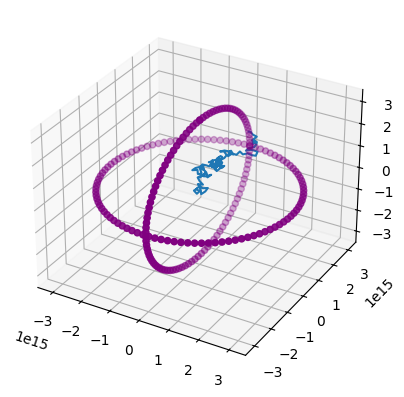

In [66]:
N = 1000
x_final, y_final, z_final, R_final, R_last_scatter = distribution_randomwalks(N)
# x_final, y_final, z_final, R_final are lists of arrays 
#print(R_final)
total_distance = np.zeros((N))

N_shells = 100
R_shells = np.linspace(0, R_cloud.value, N_shells+1)
#print('R_shells: ', R_shells)

density_of_shell = []
for index, value in enumerate(x_final):
    #print(index)
    x_values = x_final[index]
    y_values = y_final[index]
    z_values = z_final[index]
    R_values = R_final[index]
    
    shell_bins = np.zeros(N_shells)
    #if index == 0: print('R_values: ', R_values)
    step_size = np.zeros(len(x_values))
    #print(len(step_size))
    #if index ==0: print(x_values)
    for index2, value in enumerate(x_values): 
        #if index2 ==2: print('R_values[index2]: ', R_values[index2])
        if index2 == 0: 
            step_size[index2] = np.sqrt((x_values[index2]- 0)**2 
                                    + ((y_values[index2]- 0)**2)
                                    + ((z_values[index2]- 0)**2))
        else: 
            step_size[index2] = np.sqrt((x_values[index2]- x_values[index2-1])**2 
                                    + ((y_values[index2]- y_values[index2-1])**2)
                                    + ((z_values[index2]- z_values[index2-1])**2))

        for rr in range(N_shells): 
            radius_where = np.where((R_values>R_shells[rr]) & (R_values<R_shells[rr+1]))[0]
            enclosed_volume = 4*np.pi*(R_shells[rr])**2*(R_shells[rr+1]-R_shells[rr])
            #shell_bins[rr] = len(radius_where)/enclosed_volume
            if enclosed_volume != 0.0: 
                shell_bins[rr] = len(radius_where)/enclosed_volume #shell_bins[rr] = len(radius_where)
            else: shell_bins[rr] = 0
    total_distance[index] = np.sum(step_size)
    density_of_shell.append(shell_bins)

#print(density_of_shell)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_values,y_values,z_values)

theta_sphere = np.linspace(0, 2 * np.pi, 100)
phi_sphere = np.linspace(0, np.pi, 100)
x_sphere = R_cloud.value*np.sin(theta_sphere)
y_sphere = R_cloud.value*np.cos(theta_sphere)
z_sphere = np.zeros(len(x_sphere))#R_cloud.value *np.cos(theta_sphere)
ax.scatter(x_sphere, y_sphere, z_sphere, c='purple')
ax.scatter(z_sphere, x_sphere, y_sphere, c='purple')

Text(0, 0.5, 'Count')

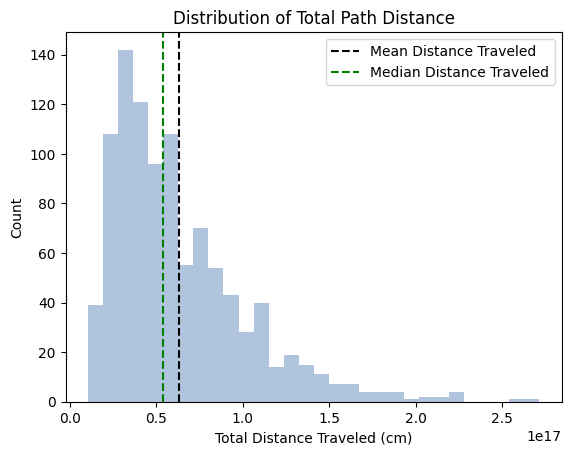

In [85]:
# Distribution of Total Path Distance 
#total_distance_topc = (total_distance* units.cm).to.pc
fig, ax = plt.subplots()
ax.hist(total_distance, bins=30, color='lightsteelblue')
ax.axvline(x=np.mean(total_distance), c='k', ls='dashed', label='Mean Distance Traveled')
ax.axvline(x=np.median(total_distance), c='green', ls='dashed', label='Median Distance Traveled')
ax.legend()
ax.set_title('Distribution of Total Path Distance')
ax.set_xlabel('Total Distance Traveled (cm)')
ax.set_ylabel('Count')

Text(0, 0.5, 'Number of particles Per Shell')

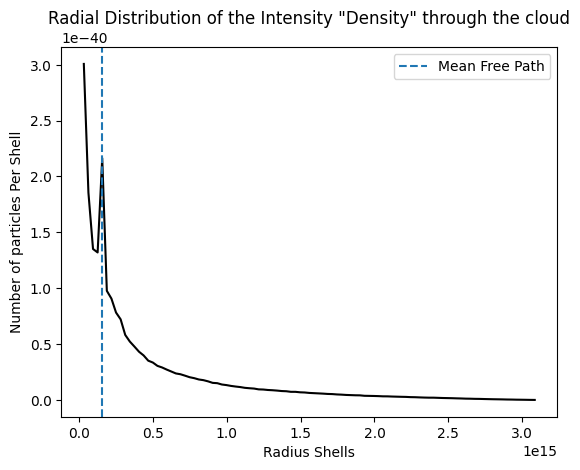

In [88]:
# Radial Distribution of the intensity "density" through the cloud
#print(density_of_shell)
density_for_graph = np.zeros(N_shells)
for index3, hh in enumerate(density_of_shell):
    #print(index3)
    #print(type(density_for_graph), type(density_of_shell[index3]))
    density_for_graph += density_of_shell[index3]

R_shell2 = np.linspace(0, R_cloud.value, N_shells)
fig, ax = plt.subplots()
ax.plot(R_shell2[1:], density_for_graph[1:], c='k')
ax.axvline(x=l_mfp.value, ls = 'dashed', label='Mean Free Path')
ax.legend()
#ax.hist(shell_bins, bins=30, color='blue')
ax.set_title('Radial Distribution of the Intensity "Density" through the cloud')
ax.set_xlabel('Radius Shells')
ax.set_ylabel('Number of particles Per Shell')

Text(0, 0.5, 'Count')

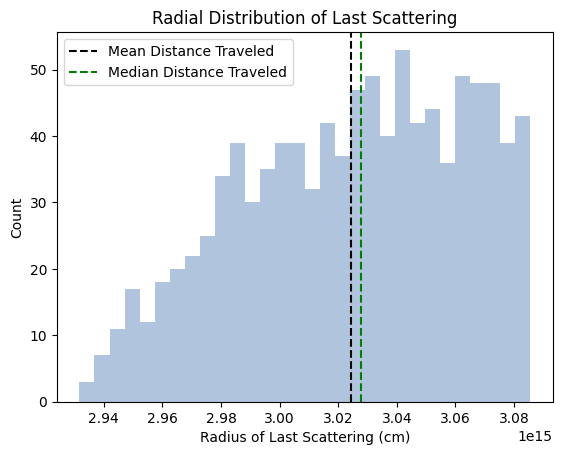

In [91]:
# Radial Distrubtion of "last scattering" for the rays

fig, ax = plt.subplots()
ax.hist(R_last_scatter, bins=30, color='lightsteelblue')
ax.axvline(x=np.mean(R_last_scatter), c='k', ls='dashed', label='Mean Distance Traveled')
ax.axvline(x=np.median(R_last_scatter), c='green', ls='dashed', label='Median Distance Traveled')
ax.legend()
ax.set_title('Radial Distribution of Last Scattering')
ax.set_xlabel('Radius of Last Scattering (cm)')
ax.set_ylabel('Count')

##Extra Credit

In [12]:
def n_r(little_r): 
    constants =(mass_cloud.value*np.e)/(mass_proton.value*(4*np.pi*R_cloud.value**3)*(2*np.e-5))
    return constants* np.e**(-little_r/R_cloud.value)

def random_walk_ec(): 
    x = []
    y = []
    z = []
    new_R_list = []
    
    new_R = 0
    new_R_list.append(new_R)
    x_new = 0
    y_new = 0
    z_new = 0
    
    while new_R <= R_cloud.value:

        dx, dy, dz = step_function()
        x_new = x_new + dx*l_mfp_ec
        y_new = y_new + dy*l_mfp_ec
        z_new = z_new + dz*l_mfp_ec
        x.append(x_new)
        y.append(y_new)
        z.append(z_new) 

        new_R = np.sqrt((x_new)**2 + y_new**2 + z_new**2)
        new_R_list.append(new_R)

    return np.array(x), np.array(y), np.array(z), np.array(new_R_list)

In [16]:
#Define Mean Free Path
N_shells = 100
little_r = np.linspace(0, R_cloud.value, N_shells+1)
n_rlittle = n_r(little_r)
l_mfp_ec = 1/(n_rlittle*sigma)

N = 1000
x_final, y_final, z_final, R_final, R_last_scatter = distribution_randomwalks(N)
# x_final, y_final, z_final, R_final are lists of arrays 
#print(R_final)
total_distance = np.zeros((N))

R_shells = np.linspace(0, R_cloud.value, N_shells+1)
#print('R_shells: ', R_shells)

density_of_shell = []
for index, value in enumerate(x_final):
    #print(index)
    x_values = x_final[index]
    y_values = y_final[index]
    z_values = z_final[index]
    R_values = R_final[index]
    
    shell_bins = np.zeros(N_shells)
    #if index == 0: print('R_values: ', R_values)
    step_size = np.zeros(len(x_values))
    #print(len(step_size))
    #if index ==0: print(x_values)
    for index2, value in enumerate(x_values): 
        #if index2 ==2: print('R_values[index2]: ', R_values[index2])
        if index2 == 0: 
            step_size[index2] = np.sqrt((x_values[index2]- 0)**2 
                                    + ((y_values[index2]- 0)**2)
                                    + ((z_values[index2]- 0)**2))
        else: 
            step_size[index2] = np.sqrt((x_values[index2]- x_values[index2-1])**2 
                                    + ((y_values[index2]- y_values[index2-1])**2)
                                    + ((z_values[index2]- z_values[index2-1])**2))

        for rr in range(N_shells): 
            radius_where = np.where((R_values>R_shells[rr]) & (R_values<R_shells[rr+1]))[0]
            enclosed_volume = 4*np.pi*(R_shells[rr])**2*(R_shells[rr+1]-R_shells[rr])
            #shell_bins[rr] = len(radius_where)/enclosed_volume
            if enclosed_volume != 0.0: 
                shell_bins[rr] = len(radius_where)/enclosed_volume #shell_bins[rr] = len(radius_where)
            else: shell_bins[rr] = 0
    total_distance[index] = np.sum(step_size)
    density_of_shell.append(shell_bins)

Text(0, 0.5, 'Count')

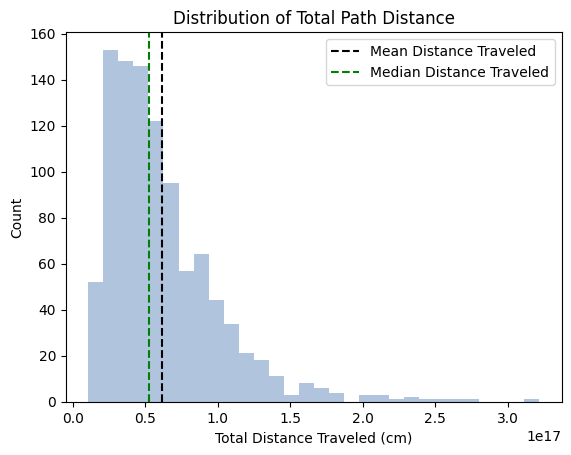

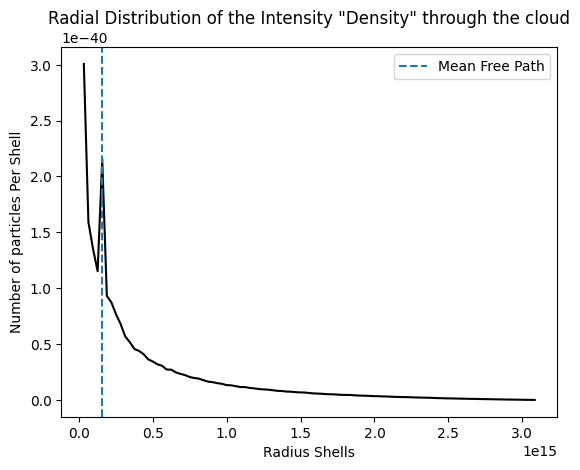

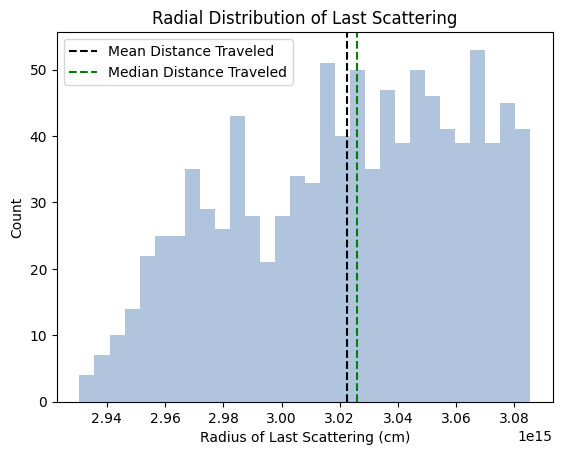

In [18]:
# Distribution of Total Path Distance 
#total_distance_topc = (total_distance* units.cm).to.pc
fig, ax = plt.subplots()
ax.hist(total_distance, bins=30, color='lightsteelblue')
ax.axvline(x=np.mean(total_distance), c='k', ls='dashed', label='Mean Distance Traveled')
ax.axvline(x=np.median(total_distance), c='green', ls='dashed', label='Median Distance Traveled')
ax.legend()
ax.set_title('Distribution of Total Path Distance')
ax.set_xlabel('Total Distance Traveled (cm)')
ax.set_ylabel('Count')

# Radial Distribution of the intensity "density" through the cloud
#print(density_of_shell)
density_for_graph = np.zeros(N_shells)
for index3, hh in enumerate(density_of_shell):
    #print(index3)
    #print(type(density_for_graph), type(density_of_shell[index3]))
    density_for_graph += density_of_shell[index3]

R_shell2 = np.linspace(0, R_cloud.value, N_shells)
fig, ax = plt.subplots()
ax.plot(R_shell2[1:], density_for_graph[1:], c='k')
ax.legend()
#ax.hist(shell_bins, bins=30, color='blue')
ax.set_title('Radial Distribution of the Intensity "Density" through the cloud')
ax.set_xlabel('Radius Shells')
ax.set_ylabel('Number of particles Per Shell')

# Radial Distrubtion of "last scattering" for the rays

fig, ax = plt.subplots()
ax.hist(R_last_scatter, bins=30, color='lightsteelblue')
ax.axvline(x=np.mean(R_last_scatter), c='k', ls='dashed', label='Mean Distance Traveled')
ax.axvline(x=np.median(R_last_scatter), c='green', ls='dashed', label='Median Distance Traveled')
ax.legend()
ax.set_title('Radial Distribution of Last Scattering')
ax.set_xlabel('Radius of Last Scattering (cm)')
ax.set_ylabel('Count')